In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import requests
import tabula as tb
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import bar_chart_race as bcr
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

## Web Scraping

In [2]:
# Set the URL to scrape
url = 'https://www.usgs.gov/centers/national-minerals-information-center/lithium-statistics-and-information'

# Set the path to the directory 
path = 'pdf_files/'

# Create the directory if it does not exist
if not os.path.exists(path):
    os.makedirs(path)

# Make a request to the web page and get its HTML
response = requests.get(url)

# Store the HTML page
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the links on the page
links = soup.find_all('a')

# Find the link before the specified href
end_href = 'https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/mineral-pubs/lithium/450494.pdf'
end_link = soup.find('a', href = end_href)

# Loop through the links and download the PDF files
count = 0
for link in links:
    # Check if the link points to a PDF file
    if link.get('href') and link.get('href').endswith('.pdf'):
        # Check if we have reached the end link
        if link == end_link:
            break
        
        # Get the URL of the PDF file
        pdf_url = link.get('href')
        
        # Download the PDF file
        response = requests.get(pdf_url)
        
        # Save the PDF file to the directory
        year = link.text.strip()
        file_name = f'lithium_{year}.pdf'
        with open(os.path.join(path, file_name), 'wb') as f:
            f.write(response.content)
        
        # Increment the file count
        count += 1

print(f'Downloaded {count} files.')

Downloaded 28 files.


## Data Wrangling

In [3]:
# Read the pdf file
path = 'pdf_files/'
file_name = 'lithium_1996.pdf'
data = tb.read_pdf(path + file_name, pages = '2', pandas_options = {'header': None})

# Initialize an empty list to store the dataframes
dfs = []

# Loop through the tables in the data and convert them to dataframes
for table in data:
    df = pd.DataFrame(table)
    dfs.append(df)

# Concatenate the dataframes
df = pd.concat(dfs, ignore_index = True)
df.head()

,0,1,2,3
0,NaN,Mine production,Reserves4,Reserve base4
1,NaN,1994 1995e,NaN,NaN
2,United States,W W,"340,000","410,000"
3,Argentinae,8 8,NA,NA
4,Australiae,"1,700 1,800","370,000","440,000"


In [4]:
# Create list of new column names
new_cols = list(string.ascii_uppercase)[:len(df.columns)]

# Move column names to first row
df = (df.T.reset_index().T.reset_index(drop = True).set_axis(new_cols, axis=1))

# Find "Reserves" word in the data frame
reserves_columns = df.columns[df.apply(lambda x: x.astype(str).str.contains('Reserves').any(), axis=0)]

# Split the text in the 'Reserves' columns and store the last word in a new column 'Z'
if len(reserves_columns) > 0:
    for col in reserves_columns:
        df['Z'] = df[col].str.split().str[-1]
    
# Select not NaN and not 0
df = df[(df['A'].notna()) & (df['A'] != 0)]

# Split text in the column A and store in the new column
df['A-1'] = df['A'].apply(lambda x: x.split(' ')[0])

# Keep only columns 'A-1' and 'Z' and drop the other columns
if 'Z' in df.columns:
    df = df.loc[:, ['A-1', 'Z']]
    # Reset the index
    df.reset_index(drop = True, inplace = True)
else:
    # Drop the original column A
    df.drop(columns=['A'], inplace = True)

    # Get the column index of 'A-1'
    idx1 = df.columns.get_loc('A-1')

    # Rearrange the column order
    new_cols = ['A-1'] + [col for col in df.columns if col not in ['A-1']]
    df = df[new_cols]

    # Keep the only first and last second column
    df = df.iloc[:, [0, -2]]
    df.columns = ['A-1', 'Z']
    
df.head()

,A-1,Z
0,United,"340,000"
1,Argentinae,NA
2,Australiae,"370,000"
3,Bolivia,—
4,Brazil,910


In [5]:
# Find the row containing the keyword
row_index = df.index[df['A-1'].str.contains('United')].tolist()[0]

# Extract all rows below the row containing the keyword
result_df = df.loc[row_index:]
result_df

,A-1,Z
0,United,"340,000"
1,Argentinae,NA
2,Australiae,"370,000"
3,Bolivia,—
4,Brazil,910
5,Canada,"180,000"
6,Chile,"1,300,000"
7,China5,NA
8,Namibiae,NA
9,Portugal,NA


## Apply Function

In [6]:
def process_pdf_file(file_path):
    lithium_files = ['lithium_1997.pdf']
    if os.path.basename(file_path) in lithium_files:
        # Read the pdf file with specific area
        data = tb.read_pdf(file_path, pages = '2', pandas_options = {'header': None}, area = (308.67, 29.37, 439.04, 568.7))
    else:
        # Read the pdf file without specific area
        data = tb.read_pdf(file_path, pages = '2', pandas_options = {'header': None})

    # Initialize an empty list to store the dataframes
    dfs = []

    # Loop through the tables in the data and convert them to dataframes
    for table in data:
        df = pd.DataFrame(table)
        dfs.append(df)

    # Concatenate the dataframes
    df = pd.concat(dfs, ignore_index=True)
    
    # Create list of new column names
    new_cols = list(string.ascii_uppercase)[:len(df.columns)]

    # Move column names to first row
    df = (df.T.reset_index().T.reset_index(drop = True).set_axis(new_cols, axis=1))
    
    # Find "Reserves" word in the data frame
    reserves_columns = df.columns[df.apply(lambda x: x.astype(str).str.contains('Reserves').any(), axis=0)]

    # Split the text in the 'Reserves' columns and store the last word in a new column 'Z'
    if len(reserves_columns) > 0:
        for col in reserves_columns:
            df['Z'] = df[col].str.split().str[-1]

    # Select not NaN and not 0
    df = df[(df['A'].notna()) & (df['A'] != 0)]

    # Split text in the column A and store in the new column
    df['A-1'] = df['A'].apply(lambda x: x.split(' ')[0])
    
    # Keep only columns 'A-1' and 'Z' and drop the other columns
    if 'Z' in df.columns:
        df = df.loc[:, ['A-1', 'Z']]
        # Reset the index
        df.reset_index(drop = True, inplace = True)
    
    else:
        # Drop the original column A
        df.drop(columns=['A'], inplace = True)

        # Get the column index of 'A-1'
        idx1 = df.columns.get_loc('A-1')

        # Rearrange the column order
        new_cols = ['A-1'] + [col for col in df.columns if col not in ['A-1']]
        df = df[new_cols]
    
        # Keep the only first and last second column from lithium_1996.pdf to lithium_2009.pdf
        if "lithium_1996.pdf" <= os.path.basename(file_path) <= "lithium_2010.pdf":
            df = df.iloc[:, [0, -2]]
        else:
            # Keep the only first and last column 
            df = df.iloc[:, [0, -1]]
        
        # Rename df columns
        df.columns = ['A-1', 'Z']

    # Find the row containing the keyword
    row_index = df.index[df['A-1'].str.contains('United')].tolist()[0]

    # Extract all rows below the row containing the keyword
    result_df = df.loc[row_index:]

    # Extract the year from the file name
    year = os.path.basename(file_path).split('_')[1].split('.')[0]

    # Add the year as a new column
    result_df['year'] = year

    return result_df

In [7]:
# Set the path to the directory 
path = 'pdf_files/'

# Create the directory if it does not exist
if not os.path.exists(path):
    os.makedirs(path)

# Loop through the files in the directory
dataframes = []
for file_name in os.listdir(path):
    if file_name.endswith('.pdf'):
        file_path = os.path.join(path, file_name)
        #print("Processing file:", file_path)
        df = process_pdf_file(file_path)
        #print("Resulting dataframe:", df)
        dataframes.append(df)

# Concatenate all the dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index = True)
final_df.head()

Got stderr: Mar 24, 2023 10:17:24 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Mar 24, 2023 10:17:25 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 24, 2023 10:17:26 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



,A-1,Z,year
0,United,"340,000",1996
1,Argentinae,NA,1996
2,Australiae,"370,000",1996
3,Bolivia,—,1996
4,Brazil,910,1996


## Data Cleaning and Manipulation

In [8]:
# See the data info
final_df.info()

# Check null values in the data frame
final_df.isnull().values.sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A-1     282 non-null    object
 1   Z       282 non-null    object
 2   year    282 non-null    object
dtypes: object(3)
memory usage: 6.7+ KB


0

In [9]:
# Change the column names
final_df.columns = ['Country', 'Reserves', 'Year']
final_df.head()

,Country,Reserves,Year
0,United,"340,000",1996
1,Argentinae,NA,1996
2,Australiae,"370,000",1996
3,Bolivia,—,1996
4,Brazil,910,1996


In [10]:
# Get the unique values from the country column
final_df['Country'].unique()

array(['United', 'Argentinae', 'Australiae', 'Bolivia', 'Brazil',
       'Canada', 'Chile', 'China5', 'Namibiae', 'Portugal', 'Russia5',
       'Zaire', 'Zimbabwe', 'World', 'eArgentina', 'eAustralia', '5China',
       'eNamibia', 'China', 'Russiae', 'Russia', 'Argentina', 'Australia',
       'China4', 'Namibia', 'Other7', 'Other'], dtype=object)

In [11]:
# Define the country names and their patterns
countries = {
    'Argentina': r"^(e|\d)?Argentina(e|\d)?$",
    'Australia': r"^(e|\d)?Australia(e|\d)?$",
    'China': r"^(e|\d)?China(e|\d)?$",
    'Namibia': r"^(e|\d)?Namibia(e|\d)?$",
    'Russia': r"^(e|\d)?Russia(e|\d)?$",
}

# Define a function to replace country names in the country column
def replace_country_names(column):
    for country, pattern in countries.items():
        # Use regular expressions to match the pattern and replace with country names
        column = column.str.replace(pattern, country)
    return column

# Call the function
final_df['Country'] = replace_country_names(final_df['Country'])
final_df['Country'].unique()

array(['United', 'Argentina', 'Australia', 'Bolivia', 'Brazil', 'Canada',
       'Chile', 'China', 'Namibia', 'Portugal', 'Russia', 'Zaire',
       'Zimbabwe', 'World', 'Other7', 'Other'], dtype=object)

In [12]:
# Change 'United' to 'United States' in the country column
final_df['Country'] = final_df['Country'].replace('United', 'United States', regex = True)

# Change 'Zaire' to 'Democratic Republic of the Congo' in the country column
final_df['Country'] = final_df['Country'].replace('Zaire', 'Democratic Republic of the Congo', regex = True)

In [13]:
# Drop unwanted values from the country column
final_df = final_df[~final_df['Country'].isin(['World', 'Other', 'Other7'])]
final_df['Country'].unique()

array(['United States', 'Argentina', 'Australia', 'Bolivia', 'Brazil',
       'Canada', 'Chile', 'China', 'Namibia', 'Portugal', 'Russia',
       'Democratic Republic of the Congo', 'Zimbabwe'], dtype=object)

In [14]:
# Check column reserves
final_df['Reserves'].unique()

array(['340,000', 'NA', '370,000', '—', '910', '180,000', '1,300,000',
       '23,000', '150,000', '3,000,000', '38,000', '160,000', '190,000',
       '540,000', '170,000', '800,000', '580,000', '7,500,000', '850,000',
       '64,000', '3,500,000', '10,000', '970,000', '1,000,000', '46,000',
       '60,000', '1,500,000', '48,000', '2,000,000', '3,200,000',
       '1,600,000', '35,000', '72,700,000', '54,000', '8,000,000',
       '70,000', '630,000', '1,700,000', '62,800,000', '95,000',
       '8,600,000', '230,000', '750,000', '1,900,000', '64,700,000',
       '530,000', '9,200,000', '220,000', '2,200,000', '75,700,000',
       '2,700,000', '76,200,000', '250,000', '930,000', '9,300,000',
       '310,000'], dtype=object)

In [15]:
# Drop unwanted characters
final_df['Reserves'] = final_df['Reserves'].replace('NA', np.nan, regex = True)
final_df['Reserves'] = final_df['Reserves'].replace('—', np.nan, regex = True)
final_df['Reserves'] = final_df['Reserves'].replace(',', '', regex = True)

In [16]:
# Convert columns data type
final_df[['Reserves', 'Year']] = final_df[['Reserves', 'Year']].apply(pd.to_numeric)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 0 to 279
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   263 non-null    object 
 1   Reserves  203 non-null    float64
 2   Year      263 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ KB


In [17]:
# List of countries to check
countries = ['United States', 'Argentina', 'Australia', 'Bolivia', 'Brazil', 'Canada', 'Chile', 'China', 'Namibia', 
             'Portugal', 'Russia', 'Democratic Republic of the Congo', 'Zimbabwe']

# Loop through years
for year in range(1996, 2024):
    # Get countries in the current year
    current_countries = final_df[final_df['Year'] == year]['Country'].unique()
    # Loop through countries
    for country in countries:
        # Check if the country is not in the current year
        if country not in current_countries:
            # Append the country to the DataFrame
            final_df = final_df.append({'Country': country, 'Reserves': np.nan, 'Year': year}, ignore_index = True)

# Sort by year in ascending order
final_df = final_df.groupby('Year').apply(lambda x: x.sort_values('Country', ascending = True)).reset_index(drop = True)

# Fill NaN reserve values with previous year's value
for country in countries:
    final_df.loc[final_df['Country'] == country, 'Reserves'] = final_df.loc[final_df['Country'] == country, 'Reserves'] \
    .fillna(method = 'ffill')

In [18]:
# Find countries with all NaN reserves
all_nan_countries = final_df.groupby('Country')['Reserves'].apply(lambda x: x.isna().sum() \
                                                                  == len(x)).loc[lambda x: x].index.tolist()

if all_nan_countries:
    print(f"The following countries have all NaN reserves: {', '.join(all_nan_countries)}")
else:
    print("No country has all NaN reserves.")

The following countries have all NaN reserves: Bolivia, Democratic Republic of the Congo, Namibia, Russia


In [19]:
# Drop some countries from the country column
final_df = final_df[~final_df['Country'].isin(['Bolivia', 'Democratic Republic of the Congo', 'Namibia', 'Russia'])]
final_df['Country'].unique()

array(['Argentina', 'Australia', 'Brazil', 'Canada', 'Chile', 'China',
       'Portugal', 'United States', 'Zimbabwe'], dtype=object)

In [20]:
# Check NaN values in the data frame
print(final_df.isna().sum())

# Check df info
print(final_df.info())

Country      0
Reserves    36
Year         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 363
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   252 non-null    object 
 1   Reserves  216 non-null    float64
 2   Year      252 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 7.9+ KB
None


In [21]:
# View data
final_df.head()

,Country,Reserves,Year
0,Argentina,NaN,1996
1,Australia,370000.0,1996
3,Brazil,910.0,1996
4,Canada,180000.0,1996
5,Chile,1300000.0,1996


## Data Visualization

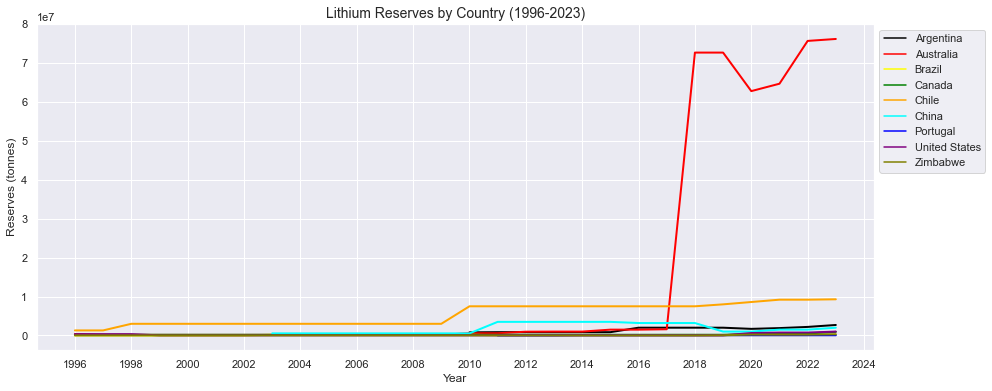

In [22]:
# Create time-series plot
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,6)})

# Custom color palette
my_palette = ['black', 'red', 'yellow', 'green', 'orange', 'cyan', 'blue', 'purple', 'olive']

ax = sns.lineplot(data = final_df, x ='Year', y = 'Reserves', hue = 'Country', palette = my_palette, legend = 'full', lw = 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend(bbox_to_anchor = (1, 1))
plt.title('Lithium Reserves by Country (1996-2023)', fontsize = 14)
plt.ylabel('Reserves (tonnes)', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.show()

In [23]:
# Check australia data
aus = final_df.loc[(final_df['Country'] == 'Australia') & (final_df['Year'] >= 2017) & (final_df['Year'] <= 2023)]
aus

,Country,Reserves,Year
274,Australia,1600000.0,2017
287,Australia,72700000.0,2018
300,Australia,72700000.0,2019
313,Australia,62800000.0,2020
326,Australia,64700000.0,2021
339,Australia,75700000.0,2022
352,Australia,76200000.0,2023


In [24]:
# Select australia data from year 2018-203
aus_res = final_df.loc[(final_df['Country'] == 'Australia') & (final_df['Year'] >= 2018) & (final_df['Year'] <= 2023)]
print(aus_res)

# Remove the first number in the reserves column since it's a footnote indication
aus_res['Reserves'] = aus_res['Reserves'].apply(lambda x: float(str(x)[1:]))
print(aus_res)

       Country    Reserves  Year
287  Australia  72700000.0  2018
300  Australia  72700000.0  2019
313  Australia  62800000.0  2020
326  Australia  64700000.0  2021
339  Australia  75700000.0  2022
352  Australia  76200000.0  2023
       Country   Reserves  Year
287  Australia  2700000.0  2018
300  Australia  2700000.0  2019
313  Australia  2800000.0  2020
326  Australia  4700000.0  2021
339  Australia  5700000.0  2022
352  Australia  6200000.0  2023


In [25]:
# Insert updated values to the final df
final_df.loc[(final_df['Country'] == 'Australia') & (final_df['Year'] >= 2018) & (final_df['Year'] <= 2023)] = aus_res
print(final_df.loc[(final_df['Country'] == 'Australia') & (final_df['Year'] >= 2018) & (final_df['Year'] <= 2023)])

       Country   Reserves  Year
287  Australia  2700000.0  2018
300  Australia  2700000.0  2019
313  Australia  2800000.0  2020
326  Australia  4700000.0  2021
339  Australia  5700000.0  2022
352  Australia  6200000.0  2023


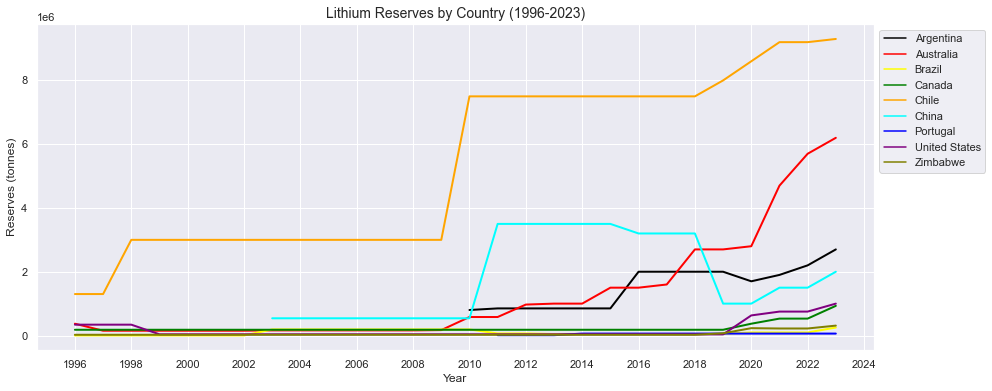

In [26]:
# Visualize time-series plot again
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,6)})

# Custom color palette
my_palette = ['black', 'red', 'yellow', 'green', 'orange', 'cyan', 'blue', 'purple', 'olive']

ax = sns.lineplot(data = final_df, x ='Year', y = 'Reserves', hue = 'Country', palette = my_palette, legend = 'full', lw = 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend(bbox_to_anchor = (1, 1))
plt.title('Lithium Reserves by Country (1996-2023)', fontsize = 14)
plt.ylabel('Reserves (tonnes)', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.show()

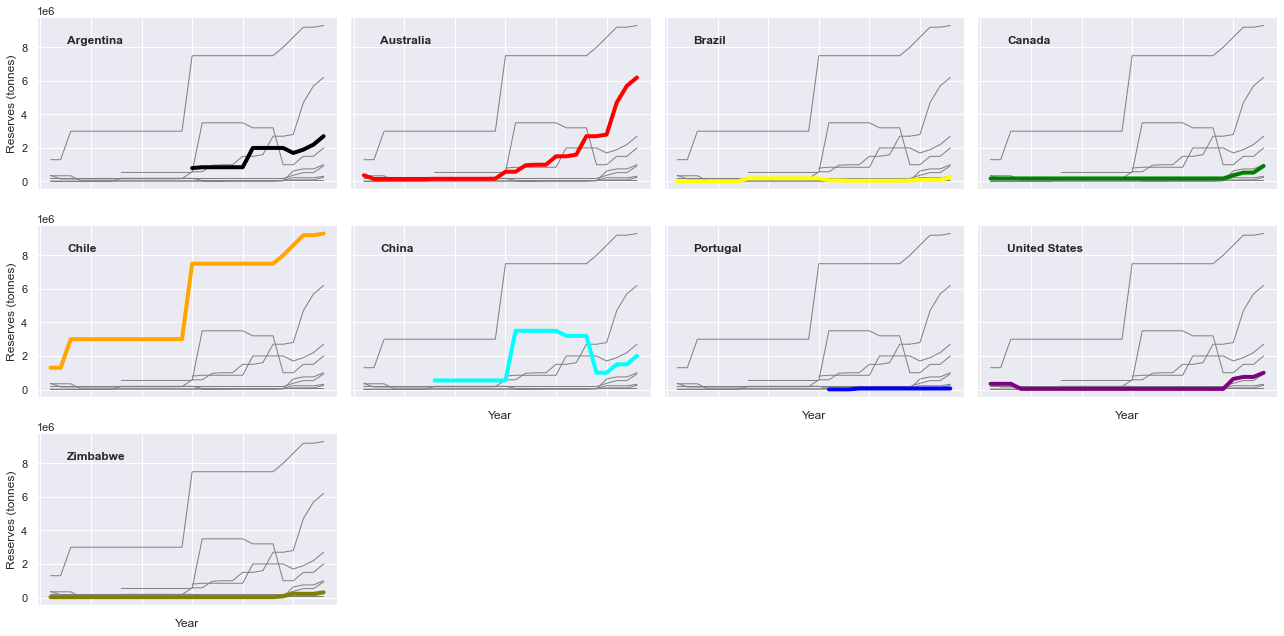

In [27]:
# Create multiple time-series plots
g = sns.relplot(data = final_df, x = 'Year', y = 'Reserves', col = 'Country', hue = 'Country', kind = 'line', 
                palette = my_palette, linewidth = 4, zorder = 5, col_wrap = 4, height = 3, aspect = 1.5, legend = False)

# Add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(0.1, 0.85, time, transform = ax.transAxes, fontweight = 'bold')
    sns.lineplot(data = final_df, x = 'Year', y = 'Reserves', units = 'Country', estimator = None, color= '0.5', 
                 linewidth = 1, ax = ax)

ax.set_xticklabels([])
g.set_titles('')
g.set_axis_labels('Year','Reserves (tonnes)')
g.tight_layout()

In [28]:
# Convert the integer column to a datetime column
final_df['Year'] = pd.to_datetime(final_df['Year'], format = '%Y')
final_df.head()

,Country,Reserves,Year
0,Argentina,NaN,1996-01-01
1,Australia,370000.0,1996-01-01
3,Brazil,910.0,1996-01-01
4,Canada,180000.0,1996-01-01
5,Chile,1300000.0,1996-01-01


In [29]:
# Keep only year value
final_df['Year'] = final_df['Year'].dt.strftime('%Y')
final_df.head()

,Country,Reserves,Year
0,Argentina,NaN,1996
1,Australia,370000.0,1996
3,Brazil,910.0,1996
4,Canada,180000.0,1996
5,Chile,1300000.0,1996


In [30]:
# Save to csv file
final_df.to_csv('df_lithium.csv', index = False)

In [31]:
# Transform the data
plot_df = final_df.pivot_table(values = 'Reserves',index = ['Year'], columns = 'Country')
plot_df.head()

Country,Argentina,Australia,Brazil,Canada,Chile,China,Portugal,United States,Zimbabwe
Year,,,,,,,,,
1996,NaN,370000.0,910.0,180000.0,1300000.0,NaN,NaN,340000.0,23000.0
1997,NaN,150000.0,910.0,180000.0,1300000.0,NaN,NaN,340000.0,23000.0
1998,NaN,150000.0,910.0,180000.0,3000000.0,NaN,NaN,340000.0,23000.0
1999,NaN,150000.0,910.0,180000.0,3000000.0,NaN,NaN,38000.0,23000.0
2000,NaN,150000.0,910.0,180000.0,3000000.0,NaN,NaN,38000.0,23000.0


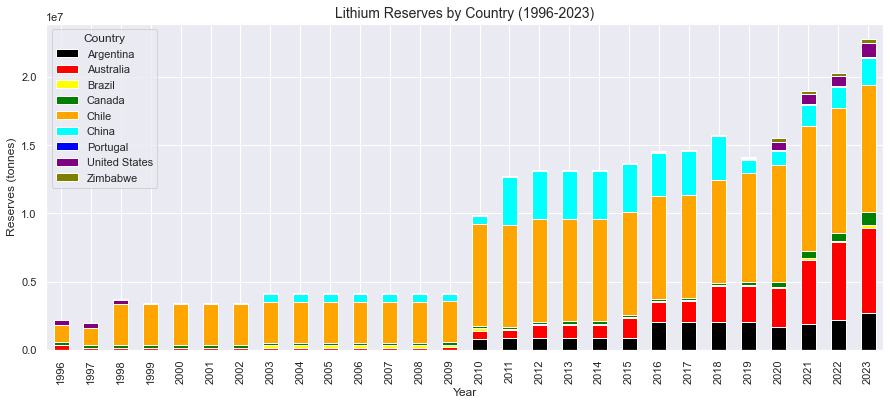

In [32]:
# Create stacked bar chart
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,6)})
plot_df.plot(kind = 'bar', stacked = True, color = my_palette)

# Labels
plt.title('Lithium Reserves by Country (1996-2023)', fontsize = 14)
plt.ylabel('Reserves (tonnes)', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.show()

In [33]:
# Set parameters for bar chart race
bcr.bar_chart_race(df = plot_df, 
                   n_bars = 9, 
                   sort = 'desc',
                   title = 'Lithium Reserves by Country (1996-2023)',
                   period_length = 450,  
                   period_label = {'x': .98, 'y': .3, 'ha': 'right', 'va': 'center'}, 
                   period_summary_func = lambda v, r: {'x': .98, 'y': .2, 
                                          's': f'Total Reserves (tonnes): {v.sum():,.0f}', 
                                          'ha': 'right', 'size': 8},   
                   bar_size = 0.7,
                   filename = 'lithium.mp4')